number of frames processed: 3447


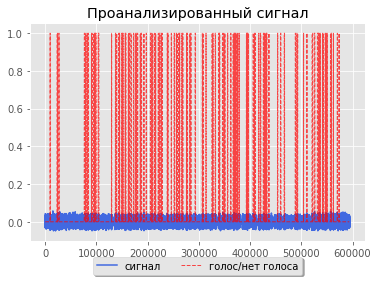

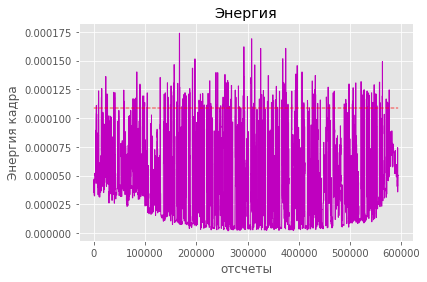

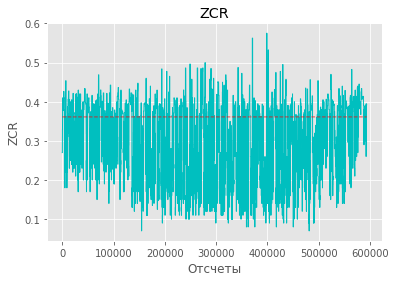

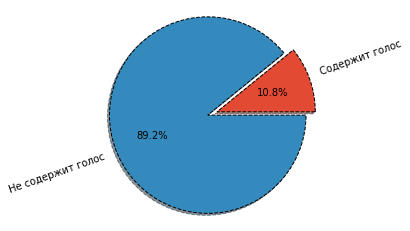

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import scipy
import soundfile as sf
from scipy.io.wavfile import write

from IPython.display import Audio
from scipy.signal.windows import hamming
path_to_file='D:/Users/inkin/Documents/01.09.2021 ИТМО/ЦОРС Столбов/Курсовая/файлы/archive/GNM_0006.wav'
#filename = r'D:/Users/inkin/Documents/01.09.2021 ИТМО/ЦОРС Столбов/Курсовая/файлы/archive/GNM_0011.wav'
y, sr = librosa.load(path_to_file, sr = 8000)


# перезапись данных (14 бит)
y = np.float16(y)
y = y*pow(2,-2)

# Нормализаиця
def normalize(x):
    return (x-min(abs(x)))/(max(x)-min(abs(x)))





# Классы

class Frame:
    
    # Thresholds init
    zcr_treshold = 0
    ste_treshold = 0


    def __init__(self, samples):

        self.frame_size = len(samples)
        self.samples = np.array(samples)
        self.classification = 0
        self.zcr = 0
        self.ste = 0
        self.classification_vector = []

        # Используется окно Хэмминга
        self.hamm_window = hamming(self.frame_size)


    # Функция для расчета ZCR
    def zero_crossing_rate(self):

        return sum(abs(np.diff(self.samples > 0))) / len(self.samples)
    
    # Функция для расчета ZCR
    def short_time_energy(self):
        temp = 0
        energy = 0
        for i, value in enumerate(self.samples):
            temp = pow(self.samples[i]*self.hamm_window[len(self.hamm_window) - 1 - i],2)
            energy += temp
        return energy / len(self.samples)
    
    
   # Параметры кадра
    def calculate_frame_parameters(self):
        self.zcr = self.zero_crossing_rate()
        self.ste = self.short_time_energy()


    # Классификация кадра как с голосом/без голоса
    def classify(self):

        self.calculate_frame_parameters()

        if self.zcr < Frame.zcr_treshold and self.ste > Frame.ste_treshold:
            self.classification = 1

        elif self.zcr > Frame.zcr_treshold and self.ste < Frame.ste_treshold:
            self.classification = 0

        else:
            self.classification = 2
            

        

    # Превратить в строковые значение
    def decodeFrame(self):
        if(self.classification == 0):
            return 'без голоса'
        elif self.classification == 1:
            return 'с речью'
        else:
            return 'DN'
    


    # Function to print the parameters
    def getParameters(self):
        print('zero crossing rate: {}'.format(self.zcr))
        print('short time energy: {}'.format(self.ste))
        print('classification: {}'.format(self.decodeFrame()))
        print('length in samples: {}'.format(len(self.samples)))
        

    # Function to plot the frame
    def plotFrame(self):
        plt.plot(self.samples)
        plt.grid()
        plt.show()

    
 
# Выставление  длины кадра
f_d = 0.1
frame_size = int(f_d * sr)
n = int(len(y)/frame_size)

# Указание минимальной длины кадра
f_d_min = 0.02
frame_size_min = int(f_d_min * sr)

df = [[0]*frame_size]*n
temp = 0

# Чтение данных
for i in range (0,n):
    df[i] = y[temp : frame_size + temp]
    temp += frame_size


# Функция для задания порогов

def setThreshold(n_threshold, df):
    thres_zcr_tab = []
    thres_ste_tab = []
    for i in range(0,n_threshold):
        frame_set = Frame(df[i])
        frame_set.calculate_frame_parameters()
        thres_ste_tab.append(frame_set.ste)
        thres_zcr_tab.append(frame_set.zcr)


    Frame.ste_treshold = max(thres_ste_tab) *0.225e1   #было подобрано опытным путем 0.2e1
    Frame.zcr_treshold = min(thres_zcr_tab)

# Первые X секунд указаны как шум
t_threshold = 0.1
n_threshold = int(t_threshold/f_d)

# Выставить пороги
setThreshold(n_threshold,df)

# массивы
frames_to_process = []
frames_processed = []
speech_frames=[] 



# Посчитать все масиивы
for i, values in enumerate(df):
    if len(frames_to_process) == 0:
        frame0 = Frame(df[i])
        frames_to_process.append(frame0)

        # Пока не пройдем все кадры
        while len(frames_to_process) != 0:
            
            
            frame0 = frames_to_process[0]

            # классифицировать кадр
            frame0.classify()
            
            # если кадр короткий, классифицировать его как "без речи"
            if frame0.frame_size < frame_size_min:
                frame0.classification = 0
                


            
            # если DN
            if frame0.classification == 2:
                
                frame1 = Frame(frame0.samples[0:int(frame0.frame_size/2)])

                frame2 = Frame(frame0.samples[int(frame0.frame_size/2):])
                
                frames_to_process.remove(frame0)

                frames_to_process.insert(0,frame1)
                frames_to_process.insert(1,frame2)

            else:
                frames_processed.append(frame0)
                frames_to_process.remove(frame0)
        
print('number of frames processed: {}'.format(len(frames_processed)))

# Превратить в графики
vector_ste_thres = []
vector_zcr_thres = []
vector_zcr=[]
vector_ste=[]
vector_classification = []
for value in frames_processed:
    
    #ZCR в графики
    temp = [value.zcr]*value.frame_size
    vector_zcr += temp

    #Энергия в графики
    temp = [value.ste]*value.frame_size
    vector_ste +=temp

    #классификация
    temp = [value.classification]*value.frame_size
    vector_classification += temp

    vector_ste_thres += [Frame.ste_treshold]*value.frame_size
    vector_zcr_thres += [Frame.zcr_treshold]*value.frame_size

#Графики
plt.style.use('ggplot')
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()

ax1.plot(y,color='royalblue', label = 'сигнал')
ax1.plot(vector_classification,color = 'r', linestyle = '--', label = 'голос/нет голоса', linewidth = 1, alpha = 0.7)
ax1.set_title('Проанализированный сигнал')
ax1.set_xlabel('отсчеты')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)


ax2.plot(vector_ste, color = 'm', linestyle = '-', label = 'Энергия', linewidth = 1)
ax2.set_xlabel('отсчеты')
ax2.set_ylabel('Энергия кадра')
ax2.set_title('Энергия')
ax2.plot(vector_ste_thres, 'r--', label = 'энегрия порог', linewidth = 1, alpha = 0.7)

ax3.plot(vector_zcr, color = 'c',linestyle = '-', label = 'ZCR', linewidth =1)
ax3.set_xlabel('Отсчеты')
ax3.set_ylabel('ZCR')
ax3.set_title('ZCR')
ax3.plot(vector_zcr_thres, 'r--', label = 'zcr порог', linewidth = 1, alpha = 0.7)





vals = [np.count_nonzero(np.asarray(vector_classification))/np.asarray(vector_classification).size*100, 100-np.count_nonzero(np.asarray(vector_classification))/np.asarray(vector_classification).size*100]
labels = ["Содержит голос", "Не содержит голос"]
explode = (0.1,0)
ax4.pie(vals, labels=labels, autopct='%1.1f%%', shadow=True, explode=explode, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)
ax4.axis("equal")
plt.savefig('saved_figure.png')
plt.show()



# Выведем файл для прослушивания

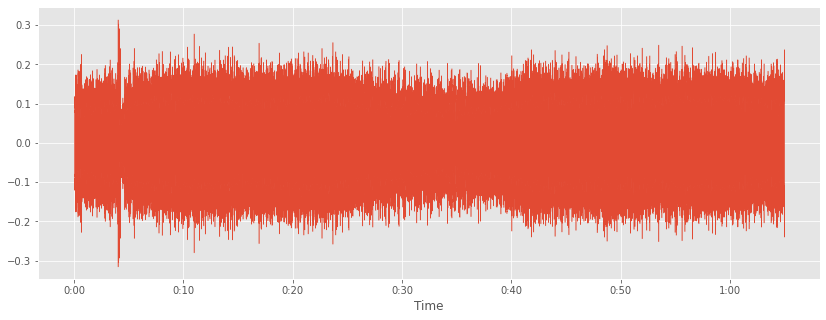

In [2]:
import IPython.display as ipd

def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveshow(wav, sr=sr)
    plt.show()
wav, sr = librosa.load(path_to_file)
draw_waveform(wav, sr)
ipd.Audio(wav, rate=sr)

In [8]:
#расчитаем долю вокализованных кадров на сигнале
np.count_nonzero(np.asarray(vector_classification))/np.asarray(vector_classification).size*100

21.346153846153847

In [5]:
#выведем статистические параметры вектора классификации для проверки
vector_classification
print('минимальное значение вектора',np.min(vector_classification))
print('список уникальных значений вектора',np.unique(vector_classification))
print('среднее значение',np.mean(vector_classification))


0
[0 1]
0.158355795148248


# Задаем переменную p

In [64]:
p=vector_classification

In [58]:
#scipy.io.wavfile.write("D:/Users/inkin/Documents/01.09.2021 ИТМО/ЦОРС Столбов/Курсовая/файлы/archive/GNM_0006_p.wav", sr, np.asarray(P))

In [57]:
#Вариант вывода сигнала с БИХ-сглаживанием
#P=scipy.signal.symiirorder1(p, 0.1,0.5 , 0.01)

In [ ]:
"""Коэффициент альфа для 
0004=0.2у1 при 0.1 сек
0006 = 0.2е1
0007= 0.2е1 при 3 сек; 
0008 = 0.1e1 0.1 sec
0011 - 0.225e1 0.1 sec
0013 - 0.225e1 0.1 sec
0014 - 0.225e1 0.1 sec

0013 = 3е1 (иследовать), указать время шума в начале 10, помогает


"""

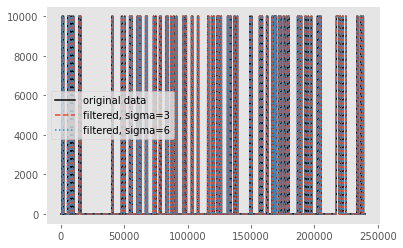

In [234]:
"""#протестируем разные способы сглаживания
from scipy.ndimage import gaussian_filter1d
j=np.asarray(t)[60000:300000]*10000
y3 = gaussian_filter1d(j, 3)
y6 = moving_average(j, 100)
plt.plot(j, 'k', label='original data')
plt.plot(y3, '--', label='filtered, sigma=3')
plt.plot(y6, ':', label='filtered, sigma=6')
plt.legend()
plt.grid()
plt.show()"""


# Зададим переменную t, с которой и будем работать. Изменим все значения сигнала с 0 на 1, если в окне анализа длиной 2500 отсчетов будет обнаружена речевая активность

In [66]:
t=np.array(p)
j=0
window=2500
for i in range(window,len(t)+1, window):
    if sum(t[j:i]) > 0: t[j:i]=1
    j+=window
if sum(t[j:len(t)]) > 0: t[j:len(t)]=1
print(j)

510000


In [67]:
#убедимся, что размер измененного сигнала равен размеру оригинального
np.shape(t)==np.shape(p)

True

# Модифицируем сигнал, чтобы его можно было рассмотреть в SIS

In [68]:
newsig=t*1000000000

# Сохраним сигнал в новый файл

In [69]:
scipy.io.wavfile.write("D:/Users/inkin/Documents/01.09.2021 ИТМО/ЦОРС Столбов/Курсовая/файлы/archive/GNM_0006_p_m_m_avg.wav", 8000, np.asarray(newsig))